In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# this is here to accomodate the old version of calculating the avg psd
# but the new version opens up a fits file that already has all the data
class psd_avg_obj:
    def __init__(self, fitsfilename):
        fd = fits.open(fitsfilename)
        psd_data = fd[1].data
        self.k_radial = psd_data.k_radial / u.m
        self.psd_radial_cal = psd_data.psd_radial * u.m**2 * u.nm**2
        
        hdr = fd[0].header
        self.k_min = hdr['kmin']/u.m
        self.k_max = hdr['kmax']/u.m
        self.npix_diam = hdr['diam_pix']
        self.delta_k = hdr['delta_k']/u.m
        side = hdr['oversamp']
        self.psd_cal = np.zeros((side, side)) # filler for the pre-existing code
        
        self.rms_tot = hdr['rms_tot']*u.nm

In [4]:
# set initial conditions
opt_parms = {'ca' : 100,
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 3,
             'kmid_ll': 100/ u.m,
             'khigh_ll': 1000/u.m,
             'label': 'ncpc'}

# load the data
ncpc = psd_avg_obj(fitsfilename='radial/psd_{0}.fits'.format(opt_parms['label']))

In [6]:
%%time
ist = [0, 10, 62, 442]
iend = ist[1:]
iend.append(len(ncpc.k_radial)-1)
rms_sr = [0.0005*u.nm, 0.00005*u.nm, 0.00005*u.nm, 0.00005*u.nm]
psd_weight = [1.0, 1.0, 1.0, 1.0]
k_limit = [np.amin(ncpc.k_radial)/10, np.amax(ncpc.k_radial)*10]
surf_unit = (ncpc.psd_radial_cal.unit * (ncpc.k_radial.unit**2))**(0.5)
mdl_set=[]
x0 = [[1.0e-3, 1.0e-3, 1.0e-3, 1.0e-3],
      [1.0e-3, 1.0e-3, 1.0e-5, 1.0e-6],
      [1.0e-5, 1.0e-5, 1.0e-5, 1.0e-5],
      [1.0e-4, 1.0e-4, 1.0e-4, 1.0e-4]]
for j in range(0, len(ist)):
    mdl = psd.model_single(region_num=j)
    mdl.load_data(ind_range=[ist[j],iend[j]], psd_obj=ncpc)
    mdl.calc_psd_parm(rms_sr=rms_sr[j], x0=x0[j])#, ratio_mode=False)
    mdl.calc_model_total(psd_weight=psd_weight[j], k_spacing=ncpc.delta_k*0.2, k_limit=k_limit)
    mdl_set.append(mdl)

# model sum with a total refit
ms_refit = psd.model_combine(mdl_set=mdl_set, avg_psd=ncpc)
ms_refit.calc_refit()
ms_refit.calc_error()
ms_refit.calc_psd_rms()

/home/jhen/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 12.2 s, sys: 759 ms, total: 12.9 s
Wall time: 12.3 s


/home/jhen/XWCL/code/model_kit/model_kit/psd_functions.py:686: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/jhen/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


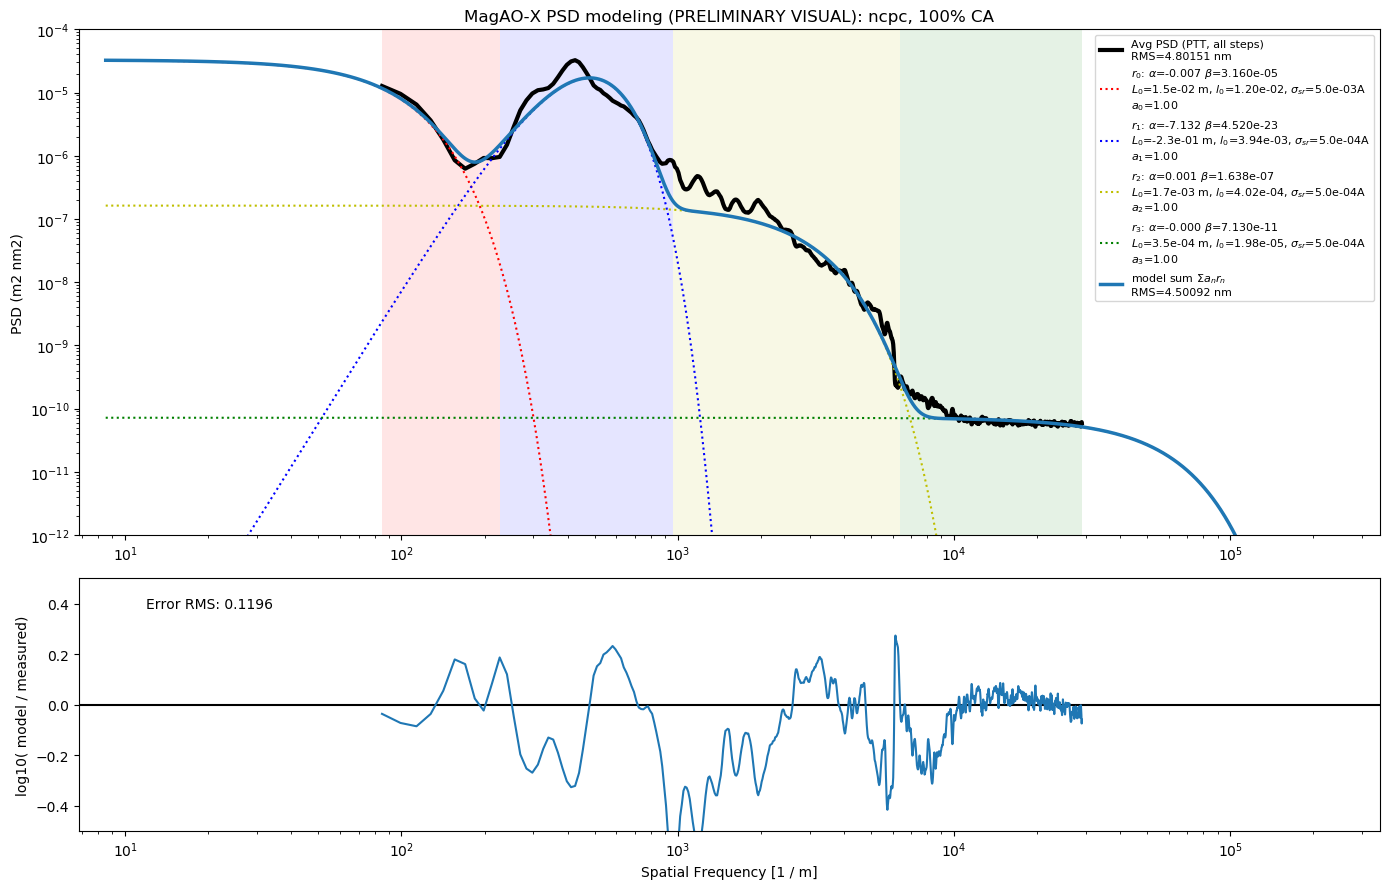

In [7]:
psd.plot_model2(mdl_set, ms_refit, ncpc, opt_parms, psd_range=[1e-4, 1e-12])

In [8]:
# set the spatial frequency regions based on the index values
k_start = []
k_end = []
for k in range(0, len(ist)):
    k_start.append(ncpc.k_radial[ist[k]].value)
    k_end.append(ncpc.k_radial[iend[k]].value)
k_start*=ncpc.k_radial[0].unit
k_end*=ncpc.k_radial[0].unit

# set the names
parm_name = 'psd_{0}'.format(opt_parms['label'])
weight_name = parm_name + '_weight'
rms_name = parm_name + '_rms'

# set the PSD dictionary values
psd_dict = {parm_name: ms_refit.psd_parm,
            weight_name: psd_weight,
            rms_name: ncpc.rms_tot,
            'k_start': k_start,
            'k_end': k_end,
            'rms_mod': ms_refit.psd_rms_sum,
            'rms_err': ms_refit.error_rms,
            'k_range': ms_refit.k_radial_data,
            'err_data': ms_refit.error,
            'mdl_data': ms_refit.psd_radial_sum_data,
            'psd_data': ms_refit.psd_radial_data}

# save the dictionary as a .FITS table file
fits_filename = 'model_parameters/psd_parms_{0}.fits'.format(opt_parms['label'])
psd.psd_model_to_fits(psd_dict=psd_dict, opt_name=opt_parms['label'], 
                     fits_filename=fits_filename,
                     surf_unit=u.nm, lat_unit=u.m)